In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060 SUPER'

In [2]:
import torch
print(torch.__version__)

1.11.0


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import models as model

### Step1: data preparation

In [5]:
# for reproducibility set seed
torch.manual_seed(0)
np.random.seed(0)
# load training data information
train_df = pd.read_csv('COVIDxCXR-2/train.txt',sep=" ",header=None)

# add column name
train_df.columns = ['patient_id','filename','class','data_source']

# only filename and class are needed for image classification
# drop unnecessary columns
train_df = train_df.drop(['patient_id','data_source'], axis=1)

In [6]:
train_df.head()

,filename,class
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.png,negative
2,acute-respiratory-distress-syndrome-ards.png,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [7]:
# same for test set
test_df = pd.read_csv('COVIDxCXR-2/test.txt',sep=" ",header=None)
test_df.columns = ['patient_id','filename','class','data_source']
test_df = test_df.drop(['patient_id','data_source'], axis=1)

In [8]:
test_df.head()

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [9]:
train_df['class'].value_counts()

positive    16490
negative    13992
Name: class, dtype: int64

Since positive samples are more than negative ones, we need to balance the training set. Otherwise the model we create will be more biased towards positive.

In [37]:
# get negative values in class column
negative = train_df[train_df['class'] == 'negative']

# get positive values in class column
positive = train_df[train_df['class'] == 'positive']

from sklearn.utils import resample
# we downsample each class to 13990 samples
df_negative_downsampled = resample(negative, replace=True,random_state=0, n_samples = 13990)
df_positive_downsampled = resample(positive, replace=True,random_state=0, n_samples = 13990)

# concatenate
train_df = pd.concat([df_negative_downsampled,df_positive_downsampled])

from sklearn.utils import shuffle
# shuffle the dataset again to randomize it
train_df = shuffle(train_df,random_state=0)
train_df.head()

,filename,class
5974,84f7d0fd-fd19-426e-8344-b56dbc1ca6e4.png,negative
23212,A111061-12-31-1900-NA-CHEST_AP_PORT-26437-4.00...,positive
22872,A672510-12-31-1900-NA-CHEST_AP_VIEWONLY-53780-...,positive
27490,A978197-01-10-1901-NA-CHEST_AP_VIEWONLY-43070-...,positive
18910,A874838-12-31-1900-NA-CHEST_AP_VIEWONLY-76825-...,positive


In [38]:
train_df['class'].value_counts()

positive    13990
negative    13990
Name: class, dtype: int64

In [39]:
# encode the label to numbers
train_df['class'] = train_df['class'].map({'negative': 0, 'positive': 1})
test_df['class'] = test_df['class'].map({'negative': 0, 'positive': 1})

train_df.head()

,filename,class
5974,84f7d0fd-fd19-426e-8344-b56dbc1ca6e4.png,0
23212,A111061-12-31-1900-NA-CHEST_AP_PORT-26437-4.00...,1
22872,A672510-12-31-1900-NA-CHEST_AP_VIEWONLY-53780-...,1
27490,A978197-01-10-1901-NA-CHEST_AP_VIEWONLY-43070-...,1
18910,A874838-12-31-1900-NA-CHEST_AP_VIEWONLY-76825-...,1


In [40]:
# split the train data into training and validation dataset
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [41]:
#Let's see how many images for training and validation and testing

print(f"Negative and positive values of train: {train_df['class'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['class'].value_counts()}")
print(f"Negative and positive values of test: {test_df['class'].value_counts()}")

Negative and positive values of train: 1    12623
0    12559
Name: class, dtype: int64
Negative and positive values of validation: 0    1431
1    1367
Name: class, dtype: int64
Negative and positive values of test: 1    200
0    200
Name: class, dtype: int64


In [82]:
# define directory path
train_path = 'COVIDxCXR-2/train'
test_path = 'COVIDxCXR-2/test'

# define function inherited from Dataset class to get data with indices
from torch.utils.data import Dataset
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx,0])

        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.data_frame.iloc[idx,-1]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [83]:
training_data = CustomImageDataset(
    data_frame=train_df,
    root_dir=train_path,
    transform=transforms.Compose([
        
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


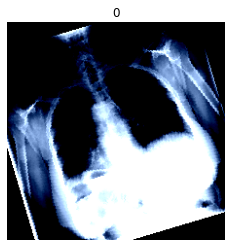

In [84]:
# show sample images
temp_img, temp_label = training_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

In [85]:
validation_data = CustomImageDataset(
    data_frame=valid_df,
    root_dir=train_path,
    transform=transforms.Compose([
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

test_data  = CustomImageDataset(
    data_frame=test_df,
    root_dir=test_path,
    transform=transforms.Compose([
        transforms.Resize([224,244],transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


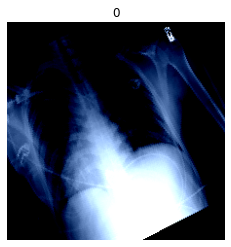

In [86]:
temp_img, temp_label = validation_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


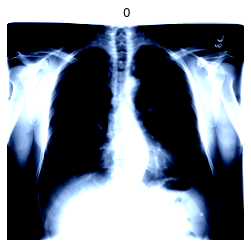

In [87]:
temp_img, temp_label = test_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

In [3]:
from torch.utils.data import DataLoader

trainloader = DataLoader(training_data, batch_size=64,shuffle=True,num_workers=0)
validloader = DataLoader(validation_data, batch_size=64,shuffle=True,num_workers=0)
testLoader = DataLoader(test_data,batch_size=64,shuffle=True,num_workers=0)

NameError: name 'training_data' is not defined

### Step2: import pretrained models
Replace last layer and train

In [89]:
# import and try the pretrained model
from torchvision import models
resnet18 = models.resnet18(pretrained=True)
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.cuda(),labels.cuda()
resnet18.cuda()
outputs = resnet18(inputs)
outputs.size()


torch.Size([64, 1000])

In [112]:
# replace last layer and train
# will replace the last layer with one that predicts the 2 classes. 
# The network weights will be fixed expected for the last layer that is trained
import time, copy
num_classes = 2
batch_size = 64
num_epochs = 20
feature_extract = True


In [117]:

# define train_model function to handle the training and validation of a given model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [99]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [100]:
def test_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

#### ResNet34

In [122]:
resnet34 = models.resnet34(pretrained=True)

# freeze all model parameters
set_parameter_requires_grad(resnet34, feature_extract)

dataloaders_dict = {'train':trainloader,'val':validloader}

# new final layer with 2 classes
num_features = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(num_features, 2)

resnet34 = resnet34.to(device)
# create the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34.fc.parameters(), lr=0.01, momentum = 0.9)

In [123]:
next(resnet34.parameters()).is_cuda

True

In [124]:
# train and validate
resnet34,hist_2 = train_model(resnet34,dataloaders_dict, criterion,optimizer,num_epochs=num_epochs, is_inception=False)


Epoch 0/19
----------
train Loss: 0.3564 Acc: 0.8553
val Loss: 0.2738 Acc: 0.8856

Epoch 1/19
----------
train Loss: 0.3060 Acc: 0.8798
val Loss: 0.2438 Acc: 0.9099

Epoch 2/19
----------
train Loss: 0.3036 Acc: 0.8846
val Loss: 0.2540 Acc: 0.8942

Epoch 3/19
----------
train Loss: 0.3123 Acc: 0.8821
val Loss: 0.3464 Acc: 0.8767

Epoch 4/19
----------
train Loss: 0.2948 Acc: 0.8878
val Loss: 0.2737 Acc: 0.8821

Epoch 5/19
----------
train Loss: 0.3141 Acc: 0.8821
val Loss: 0.2584 Acc: 0.9006

Epoch 6/19
----------
train Loss: 0.3340 Acc: 0.8823
val Loss: 0.2610 Acc: 0.9049

Epoch 7/19
----------
train Loss: 0.3053 Acc: 0.8863
val Loss: 0.3174 Acc: 0.8785

Epoch 8/19
----------
train Loss: 0.3210 Acc: 0.8806
val Loss: 0.3383 Acc: 0.8746

Epoch 9/19
----------
train Loss: 0.3117 Acc: 0.8869
val Loss: 0.2943 Acc: 0.8838

Epoch 10/19
----------
train Loss: 0.2979 Acc: 0.8877
val Loss: 0.2537 Acc: 0.9060

Epoch 11/19
----------
train Loss: 0.2948 Acc: 0.8907
val Loss: 0.3422 Acc: 0.8756

Ep

In [125]:
test_accuracy(testLoader, resnet34)


Got 303 / 400 with accuracy 75.75


#### MobileNet

In [127]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [128]:
# freeze all model parameters
set_parameter_requires_grad(mobilenet_v3_small, feature_extract)

dataloaders_dict_2 = {'train':trainloader,'val':validloader}

num_features_2 = mobilenet_v3_small.classifier[-1].in_features
has_bias = False if mobilenet_v3_small.classifier[-1].bias == None else True

# replace nn.Linear
mobilenet_v3_small.classifier[-1] = torch.nn.Linear(num_features_2, 2, has_bias)

mobilenet_v3_small = mobilenet_v3_small.to(device)

criterion_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(mobilenet_v3_small.classifier.parameters(), lr=0.01, momentum = 0.9)

In [129]:
mobilenet_v3_small,hist = train_model(mobilenet_v3_small,dataloaders_dict_2, criterion_2,optimizer_2,num_epochs=num_epochs, is_inception=False)

Epoch 0/19
----------
train Loss: 0.2524 Acc: 0.8950
val Loss: 0.5687 Acc: 0.7320

Epoch 1/19
----------
train Loss: 0.2201 Acc: 0.9099
val Loss: 0.2209 Acc: 0.9128

Epoch 2/19
----------
train Loss: 0.2206 Acc: 0.9103
val Loss: 0.2193 Acc: 0.9135

Epoch 3/19
----------
train Loss: 0.2166 Acc: 0.9132
val Loss: 0.2204 Acc: 0.9060

Epoch 4/19
----------
train Loss: 0.2137 Acc: 0.9144
val Loss: 0.2108 Acc: 0.9142

Epoch 5/19
----------
train Loss: 0.2129 Acc: 0.9126
val Loss: 0.2147 Acc: 0.9114

Epoch 6/19
----------
train Loss: 0.2100 Acc: 0.9139
val Loss: 0.2034 Acc: 0.9167

Epoch 7/19
----------
train Loss: 0.2153 Acc: 0.9131
val Loss: 0.2036 Acc: 0.9121

Epoch 8/19
----------
train Loss: 0.2157 Acc: 0.9124
val Loss: 0.2056 Acc: 0.9124

Epoch 9/19
----------
train Loss: 0.2158 Acc: 0.9129
val Loss: 0.2188 Acc: 0.9081

Epoch 10/19
----------
train Loss: 0.2133 Acc: 0.9148
val Loss: 0.2123 Acc: 0.9171

Epoch 11/19
----------
train Loss: 0.2152 Acc: 0.9126
val Loss: 0.2102 Acc: 0.9142

Ep

In [130]:
test_accuracy(testLoader, mobilenet_v3_small)

Got 344 / 400 with accuracy 86.00


#### googlenet

In [119]:
googlenet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Song/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


In [120]:
# freeze all model parameters
set_parameter_requires_grad(googlenet, feature_extract)

dataloaders_dict_3 = {'train':trainloader,'val':validloader}

# new final layer with 2 classes
num_features = googlenet.fc.in_features
googlenet.fc = torch.nn.Linear(num_features, 2)

googlenet = googlenet.to(device)
# create the optimizer
criterion_3 = torch.nn.CrossEntropyLoss()
optimizer_3 = torch.optim.SGD(googlenet.fc.parameters(), lr=0.01, momentum = 0.9)

In [121]:
# train and validate
googlenet,hist_3 = train_model(googlenet,dataloaders_dict_3, criterion_3,optimizer_3,num_epochs=num_epochs, is_inception=False)

Epoch 0/19
----------
train Loss: 0.3123 Acc: 0.8653
val Loss: 0.2497 Acc: 0.8953

Epoch 1/19
----------
train Loss: 0.2795 Acc: 0.8849
val Loss: 0.2170 Acc: 0.9124

Epoch 2/19
----------
train Loss: 0.2837 Acc: 0.8863
val Loss: 0.2129 Acc: 0.9135

Epoch 3/19
----------
train Loss: 0.2704 Acc: 0.8892
val Loss: 0.2261 Acc: 0.9060

Epoch 4/19
----------
train Loss: 0.2679 Acc: 0.8920
val Loss: 0.2391 Acc: 0.9039

Epoch 5/19
----------
train Loss: 0.2730 Acc: 0.8875
val Loss: 0.2240 Acc: 0.9146

Epoch 6/19
----------
train Loss: 0.2665 Acc: 0.8910
val Loss: 0.2191 Acc: 0.9128

Epoch 7/19
----------
train Loss: 0.2706 Acc: 0.8899
val Loss: 0.2256 Acc: 0.9110

Epoch 8/19
----------
train Loss: 0.2775 Acc: 0.8859
val Loss: 0.2532 Acc: 0.8917

Epoch 9/19
----------
train Loss: 0.2754 Acc: 0.8881
val Loss: 0.2155 Acc: 0.9149

Epoch 10/19
----------
train Loss: 0.2969 Acc: 0.8816
val Loss: 0.2140 Acc: 0.9135

Epoch 11/19
----------
train Loss: 0.2823 Acc: 0.8859
val Loss: 0.2217 Acc: 0.9110

Ep

In [126]:
test_accuracy(testLoader, googlenet)

Got 302 / 400 with accuracy 75.50
